In [2]:
from datascience import *
import numpy as np
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

# Google Science Fair

In this lesson, we are going to be looking at a historical dataset that has been collected on patients who have breast cancer and those who do not.

Classification problems in data science are classified under similarity-based machine learning. This approach of learning from data comes from the idea that the best way to make predictions is to look at what has happened in the past and predict the same thing again. The fundamental concepts required to build a system based on this idea are 

- Attribute Spaces
- Measures of Similarity

Our goal in analyzing this data set is to build a similarity-based model based on the nearest neighbor algorithm(also called the _k nearest neighbor_ algorithm).

- Our attribute space will consist of measurements collected on each patient characteristics, other than the class variable(which is to be predicted).

- Our chosen measure of similarity is the distance formual defined as the [Euclidean Distance](https://en.wikipedia.org/wiki/Euclidean_distance).

In [7]:
patients = Table.read_table('breast-cancer.csv').drop('ID')
patients.take(np.arange(5))

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
5,1,1,1,2,1,3,1,1,0
5,4,4,5,7,10,3,2,1,0
3,1,1,1,2,2,3,1,1,0
6,8,8,1,3,4,3,7,1,0
4,1,1,3,2,1,3,1,1,0


In [4]:
patients.group('Class')

Class,count
0,444
1,239


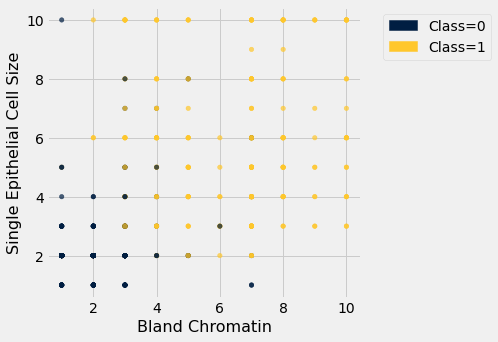

In [5]:
patients.scatter('Bland Chromatin', 'Single Epithelial Cell Size', group='Class')

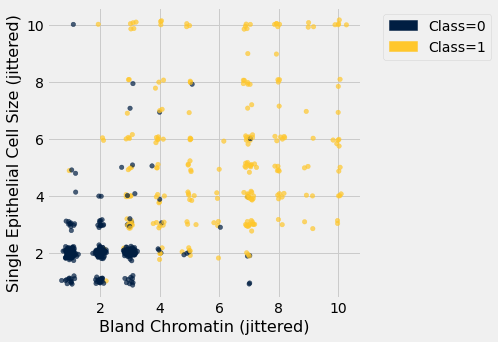

In [8]:
# For teacher's illustration

def randomize_column(a):
    return a + np.random.normal(0.0, 0.09, size=len(a))

jittered = Table().with_columns([
        'Bland Chromatin (jittered)', 
        randomize_column(patients.column('Bland Chromatin')),
        'Single Epithelial Cell Size (jittered)', 
        randomize_column(patients.column('Single Epithelial Cell Size')),
        'Class',
        patients.column('Class')
    ])

jittered.scatter(0, 1, group='Class')

## Distance ##

In [14]:
# Define a function that computes the euclidean distance for  
# ANY two arrays.

def distance(pt1, pt2):
    """Return the distance between two points, represented as arrays"""
    return np.sqrt(sum((pt1 - pt2)**2))

In [15]:
# But rows are NO arrays by default.
# The distance function above requires two arrays. How do we solve this problem
# STEP 1: Define a function that takes ANY two rows as initial input arguments
# STEP 2: Convert each rows to an array to prepare it into a form that the distance function can work with as inputs
# STEP 3: Pass the two arrays from STEP 2 above to the distance function above to compute the euclidean distance.

def row_distance(row1, row2):
    """Return the distance between two numerical rows of a table"""
    return distance(np.array(row1), np.array(row2))

In [16]:
attributes = patients.drop('Class')
attributes.show(3)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
5,1,1,1,2,1,3,1,1
5,4,4,5,7,10,3,2,1
3,1,1,1,2,2,3,1,1


In [17]:
# Putting the row_distance function to the test to compute euclidean distance
# between two array of values

row_distance(attributes.row(0), attributes.row(1))

11.874342087037917

In [18]:
row_distance(attributes.row(0), attributes.row(2))

2.2360679774997898

In [20]:
# Why this result?

row_distance(attributes.row(2), attributes.row(2))

0.0

# The Classifier

In [22]:
def distances(training, example):
    """
    Compute distance between example and every row in training.
    Return training augmented with Distance column
    """
    distances = make_array()
    attributes_only = training.drop('Class')
    
    for row in attributes_only.rows:
        distances = np.append(distances, row_distance(row, example))
    
#   ^ SAME AS DOING:
#
#   for i in np.arange(attributes_only.num_rows):
#       row = attributes_only.row(i)
#       distances = np.append(distances, row_distance(list(row), example))
        
    return training.with_column('Distance_to_ex', distances)

In [23]:
example = attributes.row(21)
example

Row(Clump Thickness=10, Uniformity of Cell Size=5, Uniformity of Cell Shape=5, Marginal Adhesion=3, Single Epithelial Cell Size=6, Bare Nuclei=7, Bland Chromatin=7, Normal Nucleoli=10, Mitoses=1)

In [24]:
distances(patients.exclude(21), example).sort('Distance_to_ex')

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class,Distance_to_ex
8,4,4,5,4,7,7,8,2,0,4.3589
10,5,7,4,4,10,8,9,1,1,4.47214
7,4,4,3,4,10,6,9,1,1,5.09902
10,3,6,2,3,5,4,10,2,1,5.38516
10,5,5,6,3,10,7,9,2,1,5.38516
10,6,6,2,4,10,9,7,1,1,5.38516
9,7,7,5,5,10,7,8,3,1,5.56776
10,6,4,3,10,10,9,10,1,1,5.56776
8,7,4,4,5,3,5,10,1,1,5.56776
10,7,7,4,5,10,5,7,2,1,5.74456


## The Closest

In [25]:
def closest(training, example, k):
    """
    Return a table of the k closest neighbors to example
    """
    return distances(training, example).sort('Distance_to_ex').take(np.arange(k))

In [26]:
closest(patients.exclude(21), example, 5)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class,Distance_to_ex
8,4,4,5,4,7,7,8,2,0,4.3589
10,5,7,4,4,10,8,9,1,1,4.47214
7,4,4,3,4,10,6,9,1,1,5.09902
10,3,6,2,3,5,4,10,2,1,5.38516
10,5,5,6,3,10,7,9,2,1,5.38516


In [27]:
closest(patients.exclude(21), example, 5).group('Class').sort('count', descending=True)

Class,count
1,4
0,1


In [33]:
# Define a function that takes a table of the closest k rows to the chosen example
# And returns the majority class, provided k is always odd to break ties.

def majority_class(topk):
    """
    Return the class with the highest count
    """
    return topk.group('Class').sort('count', descending=True).column(0).item(0)

In [34]:
# Embed the majority_class function in the new "classify" function
# which makes it convenient to specify the input arguments
# as the training partition, the example to be predicted
# and what odd value of k you would like to use.

def classify(training, example, k):
    """
    Return the majority class among the 
    k nearest neighbors of example
    """
    return majority_class(closest(training, example, k))

In [38]:
# Test the final form of the classifier on row 21 of 
# the intial data set. See the predicted class below.

classify(patients.exclude(21), example, 5)

1

In [39]:
# Compare the predicted value above with the 
# true/actual class. Do they match?

patients.take(21)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
10,5,5,3,6,7,7,10,1,1


In [40]:
# Let us classify another row, precisely row 10 of the initial data set.
# We called this new row, the new_example

new_example = attributes.row(10)
classify(patients.exclude(10), new_example, 5)

0

In [41]:
# Compare the predicted value above with the 
# true/actual class. Do they match?

patients.take(10)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
1,1,1,1,1,1,3,1,1,0


In [42]:
# Another example

another_example = attributes.row(15)
classify(patients.exclude(15), another_example, 5)

0

In [44]:
# Compare the predicted value above with the 
# true/actual class. Do they match?

patients.take(15)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
7,4,6,4,6,1,4,3,1,1


## Review of the Steps ##

- `distance(pt1, pt2)`: Returns the distance between the arrays `pt1` and `pt2`
- `row_distance(row1, row2)`: Returns the distance between the rows `row1` and `row2`
- `distances(training, example)`: Returns a table that is `training` with an additional column `'Distance'` that contains the distance between `example` and each row of `training`
- `closest(training, example, k)`: Returns a table of the rows corresponding to the k smallest distances 
- `majority_class(topk)`: Returns the majority class in the `'Class'` column
- `classify(training, example, k)`: Returns the predicted class of `example` based on a `k` nearest neighbors classifier using the historical sample `training`

## Accuracy of a Classifier ##

In [45]:
patients.num_rows

683

In [46]:
shuffled = patients.sample(with_replacement=False) # Randomly permute the rows to minimize bias.

training_set = shuffled.take(np.arange(342))
test_set  = shuffled.take(np.arange(342, 683))

In [47]:
# Accuurecy function that computes the accuracy of the classfier 
# Takes the training and test partition data set. 
# Use all rows of the training data set 
# to classify each row in the test data set.
# Then evaluate the accuracy of the classifier base on the test data set.

def evaluate_accuracy(training, test, k):
    """Return the proportion of correctly classified examples 
    in the test set"""
    test_attributes = test.drop('Class')
    num_correct = 0
    for i in np.arange(test.num_rows):
        c = classify(training, test_attributes.row(i), k) # Apply the classfication to each row in the test data set.
        num_correct = num_correct + (c == test.column('Class').item(i))
    return num_correct / test.num_rows

In [48]:
evaluate_accuracy(training_set, test_set, 5)

0.967741935483871

In [49]:
evaluate_accuracy(training_set, test_set, 3)

0.967741935483871

In [50]:
evaluate_accuracy(training_set, test_set, 11)

0.9560117302052786

In [51]:
evaluate_accuracy(training_set, test_set, 1)

0.9706744868035191

# Standardize if Necessary

In [52]:
def standard_units(x):
    return (x - np.average(x)) / np.std(x)

In [53]:
ckd = Table.read_table('ckd.csv')
ckd = ckd.relabeled('Blood Glucose Random', 'Glucose').select('Glucose', 'Hemoglobin', 'White Blood Cell Count', 'Class')

In [54]:
ckd_new = ckd.select('Class').with_columns(
    'Glucose_su', standard_units(ckd.column('Glucose')),
    'Hemoglobin_su', standard_units(ckd.column('Hemoglobin')),
    'WBC_su', standard_units(ckd.column('White Blood Cell Count'))
)

ckd_new

Class,Glucose_su,Hemoglobin_su,WBC_su
1,-0.221549,-0.865744,-0.569768
1,-0.947597,-1.45745,1.16268
1,3.84123,-1.00497,-1.27558
1,0.396364,-2.81488,0.809777
1,0.643529,-2.08395,0.232293
1,-0.561402,-1.35303,-0.505603
1,2.04928,-0.413266,0.360623
1,-0.947597,-1.28342,3.34429
1,1.87936,-1.10939,-0.409356
1,0.489051,-1.35303,1.96475


In [60]:
shuffled = ckd_new.sample(with_replacement=False)
training_set = shuffled.take(np.arange(79))
test_set = shuffled.take(np.arange(79, 158))

In [61]:
evaluate_accuracy(training_set, test_set, 3)

0.9873417721518988

In [62]:
shuffled = ckd_new.sample(with_replacement=False)
training_set = shuffled.take(np.arange(79))
test_set = shuffled.take(np.arange(79, 158))

In [63]:
evaluate_accuracy(training_set, test_set, 3)

0.9493670886075949